In [ ]:
from pathlib import Path
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt

In [43]:
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model device setup: {device}")
extractor = SuperPoint(max_num_keypoints=50).eval().to(device)
matcher = LightGlue(features="superpoint").eval().to(device)
img_ref = "2.ppm"

Model device setup: cuda


In [44]:
def random_homography(h, w, max_angle=20, max_scale=0.15, max_shift=0.05):
    # Coordenadas normalizadas dos cantos
    pts1 = np.float32([[0,0], [w,0], [w,h], [0,h]])

    # Parâmetros aleatórios
    angle = np.deg2rad(np.random.uniform(-max_angle, max_angle))
    scale = 1.0 + np.random.uniform(-max_scale, max_scale)
    tx = np.random.uniform(-max_shift, max_shift) * w
    ty = np.random.uniform(-max_shift, max_shift) * h

    # Matriz de rotação + escala
    R = np.array([
        [np.cos(angle)*scale, -np.sin(angle)*scale, tx],
        [np.sin(angle)*scale,  np.cos(angle)*scale, ty],
        [0, 0, 1]
    ])

    # Pequeno deslocamento perspectivo (efeito 3D planar)
    persp = np.array([
        [1, 0, np.random.uniform(-1e-4, 1e-4)],
        [0, 1, np.random.uniform(-1e-4, 1e-4)],
        [np.random.uniform(-1e-7, 1e-7), np.random.uniform(-1e-7, 1e-7), 1]
    ])

    H = persp @ R
    pts2 = cv2.perspectiveTransform(pts1[None, :, :], H)[0]
    return H, pts1, pts2

#Carrega a imagem base
img = cv2.imread(img_ref)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape

# Gera a homografia aleatória e aplicada a transformação na imagem base
H, pts1, pts2 = random_homography(h, w)
img_warped = cv2.warpPerspective(img, H, (w, h)) #imagem base modificada
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

cv2.imwrite("imagem_rgb.ppm", img_warped)
cv2.imwrite("imagem_gray.ppm", img_gray)


True

In [183]:
image0 = load_image(img_ref)
image1 = load_image("imagem_rgb.ppm")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
feats0_all, feats1_all = kpts0.cpu().numpy().astype(np.float32), kpts1.cpu().numpy().astype(np.float32)

kpts0 = m_kpts0.cpu().numpy().astype(np.float32)
kpts1 = m_kpts1.cpu().numpy().astype(np.float32)

num_kpts0 = feats0["keypoints"].shape[0]
pred_matches = -1 * np.ones(num_kpts0, dtype=np.int32)

if isinstance(matches, torch.Tensor):
    matches = matches.cpu().numpy()

pred_matches[matches[:, 0]] = matches[:, 1] # posição na lista de pontos correspondidos na imagem1 

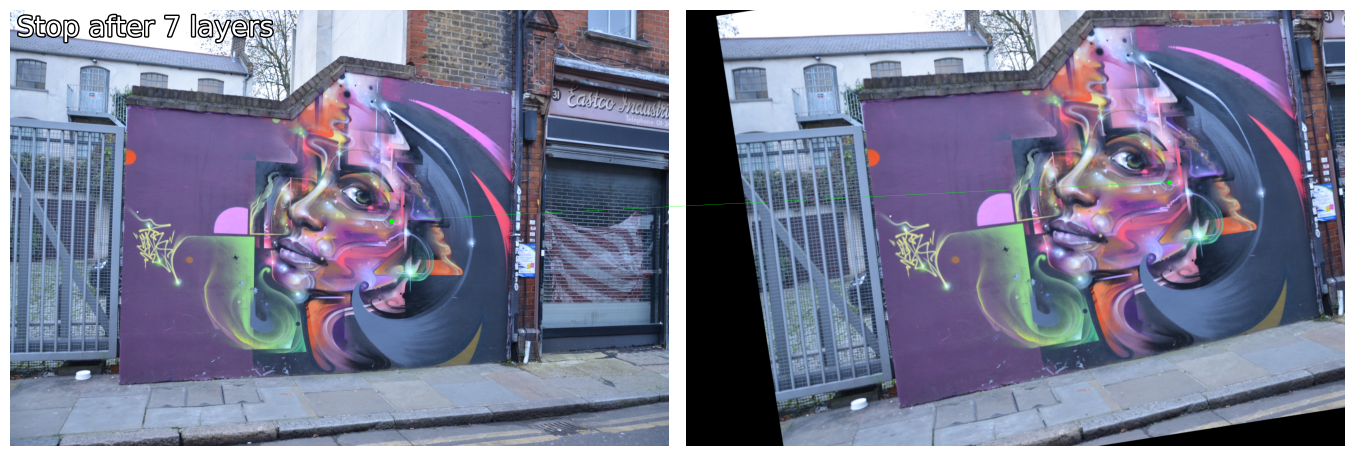

In [148]:
axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0[:1], m_kpts1[:1], color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

#kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
#viz2d.plot_images([image0, image1])
#viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

In [184]:
def compute_gt_mask(pred, gt, threshold=3.0):
    dists = np.linalg.norm(gt[:, None, :] - pred[None, :, :], axis=-1)
    min_dists = dists.min(axis=1)
    indices = dists.argmin(axis=1)
    gt_matches0 = np.where(min_dists < threshold, indices, -1)

    return torch.from_numpy(gt_matches0)

# Projeta os pontos detectados na imagem base para o espaço da imagem base modificada,
# usando a homografia aleatória que gerou a imagem base modificada
kpts1_proj = cv2.perspectiveTransform(feats0_all[None, :, :], H)[0]
gt_matches0 = compute_gt_mask(pred=kpts1, gt=kpts1_proj, threshold=3.0) # Extrai o ground-truth das correspondencias
print("gt_matches0:",gt_matches0)
#gt_matches0 = gt_matches0[matches[..., 0].cpu()]  # GT apenas para o subconjunto

gt_matches0: tensor([-1, -1, -1, -1, -1, -1, -1, -1,  0, -1,  1,  2, -1, -1,  4, -1, -1, -1,
        -1, -1,  5, -1, -1, -1, -1, -1,  7,  8, -1, -1,  9, -1, 10, -1, -1, 11,
        12, -1, 13, -1, -1, -1, 15, 16, -1, -1, 17, -1, -1, 18])


In [187]:
np.sum(gt_matches0.cpu().numpy() != -1)

np.int64(16)

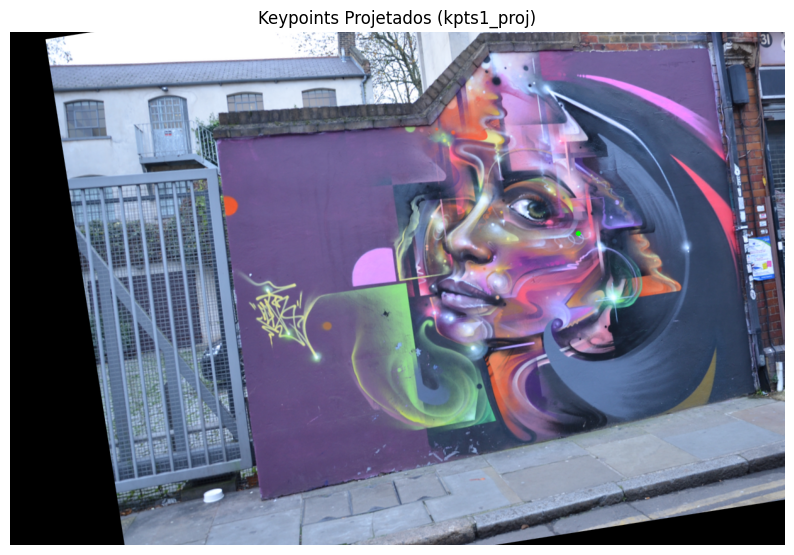

In [113]:
img_draw = cv2.imread("imagem_rgb.ppm")

# Desenha cada ponto projetado
for (x, y) in kpts1_proj[:1]:
    cv2.circle(img_draw, (int(x), int(y)), 4, (0, 255, 0), -1)  # verde

# Mostra com matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
plt.title("Keypoints Projetados (kpts1_proj)")
plt.axis("off")
plt.show()

In [190]:
def compute_metrics(feats1_all, m_kpts1, kpts1_proj, threshold=3.0):
    """
    feats1_all: todos os keypoints detectados (N x 2)
    m_kpts1: keypoints estimados (M x 2)
    kpts1_proj: keypoints ground truth projetados correspondentes a feats1_all (N x 2)
    """
    
    # Calcula erro entre os matches estimados e o ground truth
    errors = np.linalg.norm(m_kpts1.cpu().numpy() - kpts1_proj[:len(m_kpts1)], axis=1)

    # True Positives (erros menores que threshold)
    tp_mask = errors < threshold
    tp = np.sum(tp_mask)

    # False Positives (matches estimados incorretos)
    fp = np.sum(~tp_mask)

    # False Negatives: keypoints que existiam no ground truth (feats1_all)
    # mas não foram encontrados dentro do limiar de erro
    total_gt = len(feats1_all)
    fn = total_gt - tp

    # Métricas
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    mean_error = np.mean(errors) if len(errors) > 0 else np.nan

    return {
        "precision@3px": precision,
        "recall@3px": recall,
        "mean_error": mean_error,
        "tp": tp,
        "fp": fp,
        "fn": fn,
    }

In [191]:
compute_metrics(feats1_all, m_kpts1, kpts1_proj, threshold=3.0)

{'precision@3px': np.float64(0.0),
 'recall@3px': np.float64(0.0),
 'mean_error': np.float32(484.34494),
 'tp': np.int64(0),
 'fp': np.int64(19),
 'fn': np.int64(50)}